In [1]:
import re
import urllib.request as urllib2
from bs4 import BeautifulSoup
import json
import requests
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns; sns.set(style='whitegrid')
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB

IS_LOCAL = False
import os

## CONTEXTO DEL PROBLEMA A RESOLVER

En la actualidad estamos viviendo una pandemia mundial de Covid-19 que nos está afectando de manera social y económica. Sin
embargo, antes de que sucediera esta pandemia, una epidemia ha estado presente de manera alertiva como el Dengue, sobre todo en
America Latina en estos últimos años. Por ejemplo, en el Perú, los casos de Dengue ha aumentado bastante este año, donde
la mayoria de los casos se encuentra en la Amazonía peruana. En los medios de comunicación de Perú daban pocas noticias acerca
de Dengue. Sin embargo, cuando ocurrio esta pandemia, todas las noticias se enfocaron en informar acerca de los casos de 
Covid-19, dejando de lado el Dengue. El problema a resolver es si esto ocurre en el país que tiene los mayores casos de Dengue;
es decir, saber cuánta importancia le dan sus diarios mas visitados con respecto al Dengue comparándolo con los diarios de 
Perú.

In [2]:
#Una pequeña informacion acerca del Dengue
base='https://www.who.int/es/news-room/fact-sheets/detail/dengue-and-severe-dengue'
htmlBase = requests.get(base).text.replace('\n', '')
soupBase = BeautifulSoup(htmlBase,'html.parser')
info = soupBase.find_all("div", class_="list-bold separator-line")[0]
infoBase=info.find_all("li")
print("Dengue y dengue grave")
for item in infoBase:
    print("- "+item.text)

Dengue y dengue grave
- El dengue es una infección vírica transmitida por mosquitos. 
- La infección causas síntomas gripales y en ocasiones evoluciona hasta convertirse en un cuadro potencialmente mortal llamado dengue grave.
- En las últimas décadas ha aumentado enormemente la incidencia de dengue en el mundo. Alrededor de la mitad de la población del mundo corre el riesgo de contraer esta enfermedad.
- El dengue se presenta en los climas tropicales y subtropicales de todo el planeta, sobre todo en las zonas urbanas y semiurbanas.
- No hay tratamiento específico del dengue ni del dengue grave, pero la detección oportuna y el acceso a la asistencia médica adecuada disminuyen las tasas de mortalidad por debajo del 1%.


In [3]:
#Ha sido sacada de la fuente: https://www.paho.org/data/index.php/es/temas/indicadores-dengue/dengue-nacional/9-dengue-pais-ano.html
df5=pd.read_csv('W_By_Last_Available_EpiWeek_data_DENGUE.csv')
df5=df5.drop(['Incidence Rate (c)', '(SD/D) x100 (e)', 'CFR (f)', 'Serotype', 'EW', 'ID', 'Epidemiological Week (a)', 'Confirmed'], axis=1)

In [30]:
df5=df5.sort_values(by=['Total of Dengue Cases (b)'],  ascending=False)
#Tendria que seleccionar en Country Or Subregion solo los paises, ya que estan considerando paises y subregiones
df5=df5.loc[(df5["Country or Subregion"]!="The Americas") & (df5["Country or Subregion"]!="Southern Cone") & (df5["Country or Subregion"]!="Central America Ithsmus and Mexico")
      & (df5["Country or Subregion"]!="Andean Subregion")]
df5[df5["Year"]==2019].head(10)

,Country or Subregion,Deaths,Population X 1000,Severe Dengue (d),Total of Dengue Cases (b),Year
252,Brazil,789.0,208495,1453.0,2226914.0,2019
34,Mexico,191.0,130759,3357.0,268458.0,2019
121,Nicaragua,30.0,6285,1210.0,186173.0,2019
72,Colombia,87.0,49465,1406.0,127553.0,2019
183,Honduras,180.0,9158,19435.0,112708.0,2019
43,Guatemala,66.0,17245,113.0,50432.0,2019
400,El Salvador,14.0,6412,106.0,27470.0,2019
201,Latin Caribbean,53.0,26031,332.0,23472.0,2019
238,Dominican Republic,53.0,10883,328.0,20183.0,2019
143,Peru,37.0,32552,163.0,17143.0,2019


In [24]:
tmp = df5.drop(["Deaths", "Population X 1000", "Severe Dengue (d)"], axis=1)
tmp2020=tmp[tmp["Year"]==2020]
tmp2019=tmp[tmp["Year"]==2019]
tmp2018=tmp[tmp["Year"]==2018]
tmp2017=tmp[tmp["Year"]==2017]
tmp2016=tmp[tmp["Year"]==2016]

In [27]:
def draw_map(dataset, title, colorscale, reversescale=False):
    trace = go.Choropleth(
                locations = dataset['Country or Subregion'],
                locationmode='country names',
                z = dataset['Total of Dengue Cases (b)'],
                text = dataset['Country or Subregion'],
                autocolorscale =False,
                reversescale = reversescale,
                colorscale = colorscale,
                marker = dict(
                    line = dict(
                        color = 'rgb(0,0,0)',
                        width = 0.5)
                ),
                colorbar = dict(
                    title = 'Editions',
                    tickprefix = '')
            )

    data = [trace]
    layout = go.Layout(
        title = title,
        geo = dict(
            showframe = True,
            showlakes = False,
            showcoastlines = True,
            projection = dict(
                type = 'orthographic'
            )
        )
    )
    fig = dict( data=data, layout=layout )
    iplot(fig)

In [28]:
draw_map(tmp2020, 'Casos de Dengue en 2020', "Reds")

In [29]:
draw_map(tmp2019, 'Casos de Dengue en 2019', "Blues")

In [31]:
draw_map(tmp2018, 'Casos de Dengue en 2018', "Greens")

In [36]:
draw_map(tmp2017, 'Casos de Dengue en 2017', "Oranges")

In [37]:
draw_map(tmp2016, 'Casos de Dengue en 2016', "Purples")

## PREGUNTA A ABORDAR:


Se puede observar los países de América con mayor casos de Dengue en lo que va en el año 2020. Brasil lidera como uno de los
mayores en America Latina, al igual que Perú. La cuestión es si los medios de comunicacion de esos paises están informando 
de manera alertiva  acerca de los casos de dengue al igual que las noticias de Covid que vemos en el día a día. 
Hay que acotar que esta epidemia ha estado presente aproximadamente desde el 2014 y ha aumentado los casos de manera alarmante 
en estos últimos años. Para ello, vamos a analizar las últimas noticias que han sacado acerca del dengue en los diarios más
importantes de esos países (Perú y Brasil). En su buscador puse "dengue" en sus diarios y se puede notar que hay noticias 
de Covid-19 a pesar que no es la noticia que quiero informarme. Se puede decir que no están prestando mayor atención sobre 
los casos de Dengue. Sin embargo, hay otras diarios que si informan acerca de ello. Sobre ese cuestionamiento, vamos a
analizar qué país prestan mayor atención acerca de dengue relacionandolo con el Covid-19. 

Los diarios elegidos son en base a la fuente de la pegina web 'https://www.prensamundo.com/peru.html' y 'https://www.prensamundo.com/brasil.html'
que muestran los diarios mas visitados en Brasil y Peru, por ahora me voy a basar de tres de sus diarios mas visitados.


En cada diario, puse en si buscador "dengue" y saque los ultimos titulos de las noticias que salen como respuesta con su 
respectiva fecha. Para saber si estan informando acerca del Covid-19 o Dengue, puse una condición si las palabras "Covid" y
"Dengue" estan en el titulo, ya que de esa manera sabremos si estan hablando acerca de las epidemias. Voy a sacar un minimo
de 200 titulos de noticias por cada diario

### Extraccion, Preprocesamiento y Almacenamiento de Datos

In [2]:
import pymongo
client = pymongo.MongoClient()
dbDengue = client['dengueDatabase2']
dataDengue = dbDengue['denguePosts2']
dataDengue

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'dengueDatabase2'), 'denguePosts2')

In [7]:
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation+'’'+'‘'+'¡'+'¿'+'«'+'»'+'“'+'”'))
def remove_spaces(sentence: str) -> str:
    return sentence.strip()

nltk.download('stopwords')
stop_words_port = stopwords.words('portuguese') #STOPWORDS EN PORTUGUÉS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PERSONAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import pt_core_news_sm
nlp2 = pt_core_news_sm.load()

colums=["Country", "News", "Article", "Date", "Is there Dengue?", "Top News in Country (PrensaMundo)", "NER Spacy"]
data1=[]
i=0
for aux in range(40):
    i+=1
    #Pagina oficial del Oglobo
    braUrl='https://oglobo.globo.com/busca/?q=dengue&species=not%C3%ADcias&page='+str(i)
    html = requests.get(braUrl).text.replace('\n', '')
    soup = BeautifulSoup(html,'html.parser')
    info = soup.find_all("a", class_=["cor-produto busca-titulo", "cor-produto"])[8:18]
    dates = soup.find_all("span", class_=["tempo-decorrido", "busca-tempo-decorrido"])
    for j in range(10):
        row={}
        row[colums[0]]="Brazil"
        row[colums[1]]="Oglobo"
        #Prepocesamiento
        text=remove_punctuation(info[j].get("title"))
        list_parrafo=text.split(" ")
        list_order=[word for word in list_parrafo if word not in stop_words_port]
        separator=" "
        text=separator.join(list_order)
        row[colums[2]]=text
        
        row[colums[3]]=dates[j].text
        if (("Dengue" in info[j].get("title")) or ("dengue" in info[j].get("title"))): row[colums[4]]="Yes"
        else: row[colums[4]]="No"
        row[colums[5]]=2
        doc2=nlp2(text)
        aux=[(ent.text, ent.label_) for ent in doc2.ents]
        row[colums[6]]=aux
        #dataDengue.insert_one(row)#######INSERTA AL DATABASE
        data1.append(row)
#df_test=pd.DataFrame(data1)
#df_test
#infoData=pd.DataFrame(data)
#infoData.head()

In [17]:
#i=80
#i=40
i=0
data2=[]
for aux in range(40):
    i += 1
    #Pagina oficial de DiarioDaRegiao
    braUrl = 'https://www.diariodaregiao.com.br/search/?q=dengue&page='+str(i)
    html = requests.get(braUrl).text.replace('\n', '')
    soup = BeautifulSoup(html,'html.parser')
    info = soup.find_all("h2")
    dates = soup.find_all("time")
    for j in range(10):
        row={}
        row[colums[0]]="Brazil"
        row[colums[1]]="DiarioDaRegiao"
        #Prepocesamiento
        text1=remove_punctuation(info[j].text)
        text=remove_spaces(text1)
        list_parrafo=text.split(" ")
        list_order=[word for word in list_parrafo if word not in stop_words_port]
        separator=" "
        text=separator.join(list_order)
        row[colums[2]]=text
        row[colums[3]]=dates[j].get("datetime")
        if (("Dengue" in info[j].text) or ("dengue" in info[j].text)): row[colums[4]]="Yes"
        else: row[colums[4]]="No"
        row[colums[5]]=1
        doc2=nlp2(text)
        aux=[(ent.text, ent.label_) for ent in doc2.ents]
        row[colums[6]]=aux
        #dataDengue.insert_one(row)#######INSERTA AL DATABASE
        data2.append(row)
#df_test2=pd.DataFrame(data2)
#df_test2
#pd.DataFrame(data)

In [20]:
i=0
data2=[]
for aux in range(30):
    i += 1
    #Pagina oficial de Diarinho
    braUrl = 'https://diarinho.com.br/page/'+str(i)+'/?s=dengue'
    html = requests.get(braUrl).text.replace('\n', '')
    soup = BeautifulSoup(html,'html.parser')
    info = soup.find_all("h2", class_="entry-title")
    dates = soup.find_all("time", class_="entry-date published")
    for j in range(15):
        row={}
        row[colums[0]]="Brazil"
        row[colums[1]]="Diarinho"
        #Prepocesamiento
        text=remove_punctuation(info[j].text)
        list_parrafo=text.split(" ")
        list_order=[word for word in list_parrafo if word not in stop_words_port]
        separator=" "
        text=separator.join(list_order)
        row[colums[2]]=text
        row[colums[3]]=dates[j].text
        if (("Dengue" in info[j].text) or ("dengue" in info[j].text)): row[colums[4]]="Yes"
        else: row[colums[4]]="No"
        row[colums[5]]=8
        doc2=nlp2(text)
        aux=[(ent.text, ent.label_) for ent in doc2.ents]
        row[colums[6]]=aux
        #dataDengue.insert_one(row)#######INSERTA AL DATABASE
        data2.append(row)
#pd.DataFrame(data2)

In [23]:
import es_core_news_sm
nlp = es_core_news_sm.load()
stop_words_span = stopwords.words('spanish') #STOPWORDS EN ESPAÑOL

In [30]:
import es_core_news_sm
nlp = es_core_news_sm.load()

#i=0
#i=15
i=30
data3=[]
for aux in range(4):
    i += 1
    #Pagina oficial de El Comercio
    perUrl = 'https://elcomercio.pe/buscar/dengue/todas/descendiente/'+str(i)+'/?query=dengue'
    html = requests.get(perUrl).text.replace('\n', '')
    soup = BeautifulSoup(html,'html.parser')
    info = soup.find_all("a", class_="story-item__title block overflow-hidden primary-font line-h-xs mt-10")
    dates = soup.find_all("p", class_="story-item__date font-thin ml-5 text-xs text-gray-300 md:mt-5 md:ml-0")
    for j in range(30):
        row={}
        row[colums[0]]="Peru"
        row[colums[1]]="DiarioElComercio"
        #Prepocesamiento
        text=remove_punctuation(info[j].text)
        list_parrafo=text.split(" ")
        list_order=[word for word in list_parrafo if word not in stop_words_span]
        separator=" "
        text=separator.join(list_order)
        row[colums[2]]=text
       
        row[colums[3]]=dates[j].text
        if (("Dengue" in info[j].text) or ("dengue" in info[j].text)): row[colums[4]]="Yes"
        else: row[colums[4]]="No"
        row[colums[5]]=1
        doc=nlp(text)
        aux=[(ent.text, ent.label_) for ent in doc.ents]
        row[colums[6]]=aux
        #dataDengue.insert_one(row)#######INSERTA AL DATABASE
        data3.append(row) 
#pd.DataFrame(data3)

In [36]:
#i=0
i=10
data3=[]
for aux in range(10):
    i += 1
    #Pagina oficial de Peru21
    perUrl = 'https://peru21.pe/buscar/dengue/todas/descendiente/'+str(i)+'/?query=dengue'
    html = requests.get(perUrl).text.replace('\n', '')
    soup = BeautifulSoup(html,'html.parser')
    info = soup.find_all("a", class_="story-item__title block overflow-hidden primary-font line-h-xs mt-10")
    dates = soup.find_all("p", class_="story-item__date font-thin ml-5 text-xs text-gray-300 md:mt-5 md:ml-0")
    for j in range(30):
        row={}
        row[colums[0]]="Peru"
        row[colums[1]]="Peru21"
        #Prepocesamiento
        text=remove_punctuation(info[j].text)
        list_parrafo=text.split(" ")
        list_order=[word for word in list_parrafo if word not in stop_words_span]
        separator=" "
        text=separator.join(list_order)
        row[colums[2]]=text
       
        row[colums[3]]=dates[j].text
        if (("Dengue" in info[j].text) or ("dengue" in info[j].text)): row[colums[4]]="Yes"
        else: row[colums[4]]="No"
        row[colums[5]]=3
        doc=nlp(text)
        aux=[(ent.text, ent.label_) for ent in doc.ents]
        row[colums[6]]=aux
        dataDengue.insert_one(row)#######INSERTA AL DATABASE
        data3.append(row) 
#pd.DataFrame(data3)

In [74]:
colums=["Country", "News", "Article", "Date", "Is there Dengue?", "Top News in Country (PrensaMundo)", "NER Spacy"]
#i=0
i=48
data3=[]
for aux in range(2):
    i += 1
    #Pagina oficial de Correo
    perUrl = 'https://diariocorreo.pe/buscar/dengue/todas/descendiente/'+str(i)+'/?query=dengue'
    html = requests.get(perUrl).text.replace('\n', '')
    soup = BeautifulSoup(html,'html.parser')
    info = soup.find_all("a", class_="story-item__title block overflow-hidden primary-font line-h-xs mt-10")

    for j in range(30):
        row={}
        row[colums[0]]="Peru"
        row[colums[1]]="DiarioCorreo"
        #Prepocesamiento
        text=remove_punctuation(info[j].text)
        list_parrafo=text.split(" ")
        list_order=[word for word in list_parrafo if word not in stop_words_span]
        separator=" "
        text=separator.join(list_order)
        row[colums[2]]=text
     
        page=info[j].get("href")
        
        url="https://diariocorreo.pe"+page
        html = requests.get(url).text.replace('\n', '')
        soup = BeautifulSoup(html,'html.parser')
        infoDate = soup.find_all("time")[0]
        
        row[colums[3]]=infoDate.text[15:25]
        if (("Dengue" in info[j].text) or ("dengue" in info[j].text)): row[colums[4]]="Yes"
        else: row[colums[4]]="No"
        row[colums[5]]=4
        doc=nlp(text)
        aux=[(ent.text, ent.label_) for ent in doc.ents]
        row[colums[6]]=aux
        dataDengue.insert_one(row)#######INSERTA AL DATABASE
        data3.append(row)
#pd.DataFrame(data3)

### Caso Auxiliar

In [18]:
import es_core_news_sm
nlp = es_core_news_sm.load()

colums=["Country", "News", "Article", "Date", "Is there Dengue?", "Top News in Country (PrensaMundo)", "NER Spacy"]
i=0
data3=[]
for aux in range(6):
    i += 1
    #Pagina oficial de DiarioAhora Ucayali
    perUrl = 'http://proycontra.com.pe/page/'+str(i)+'/?s=dengue'
    html = requests.get(perUrl).text.replace('\n', '')
    soup = BeautifulSoup(html,'html.parser')
    info = soup.find_all("h2", class_="entry-title")
    date = soup.find_all("time")
    j=0
    for item in info:
        row={}
        row[colums[0]]="Peru"
        row[colums[1]]="DiarioAhora"
        #Prepocesamiento
        text=remove_punctuation(item.text)
        list_parrafo=text.split(" ")
        list_order=[word for word in list_parrafo if word not in stop_words_span]
        separator=" "
        text=separator.join(list_order)
        row[colums[2]]=text
        row[colums[3]]=date[j].text
        j+=1
        if (("Dengue" in item.text) or ("dengue" in item.text)): row[colums[4]]="Yes"
        else: row[colums[4]]="No"
        row[colums[5]]=4
        doc=nlp(text)
        aux=[(ent.text, ent.label_) for ent in doc.ents]
        row[colums[6]]=aux
        ##dataDengue.insert_one(row)#######INSERTA AL DATABASE
        data3.append(row)
pd.DataFrame(data3)

,Country,News,Article,Date,Is there Dengue?,Top News in Country (PrensaMundo),NER Spacy
0,Peru,DiarioAhora,Donan polos lucha dengue Loreto,"junio 9, 2020",Yes,4,"[(Loreto, LOC)]"
1,Peru,DiarioAhora,“El Dengue disminuido En loreto”,"marzo 21, 2020",Yes,4,"[(El Dengue, MISC), (En loreto, MISC)]"
2,Peru,DiarioAhora,Tipos dengueen casos puede ser mortal,"marzo 12, 2020",Yes,4,"[(Tipos, LOC)]"
3,Peru,DiarioAhora,Confirman 2 muertos Dengue SM,"marzo 12, 2020",Yes,4,"[(Confirman 2 muertos Dengue SM, MISC)]"
4,Peru,DiarioAhora,Confirman 11 muertos Dengue Loreto,"marzo 9, 2020",Yes,4,"[(Confirman 11 muertos Dengue Loreto, MISC)]"
5,Peru,DiarioAhora,Casi arde camioneta lucha Dengue,"marzo 9, 2020",Yes,4,"[(Dengue, MISC)]"
6,Peru,DiarioAhora,Registran 833 casos dengue confirmados,"marzo 4, 2020",Yes,4,[]
7,Peru,DiarioAhora,Hay 300 casos dengue Morales,"febrero 28, 2020",Yes,4,"[(Morales, PER)]"
8,Peru,DiarioAhora,Intensifican fumigación combatir dengue,"febrero 15, 2020",Yes,4,"[(Intensifican, LOC)]"
9,Peru,DiarioAhora,Intensifican fumigación combatir dengue,"febrero 15, 2020",Yes,4,"[(Intensifican, LOC)]"


In [ ]:
#He intentado de scrapear diarios de la region selva, ya que en esas zonas se han detectado mayor casos de dengue. Sin embargo,
#los diarios que he encontrado sacan pocas noticias acerca de ello, o ni siquiera hablan de ello. Por ejemplo, en este diario 
#de Ucayali, si hay noticias de dengue, pero son muy pocos para analizarlo. Si encuentro un diario que hablan de ello en una
#cantidad correcta, lo involucro al analisis

### DATASET DEL TEMA

In [3]:
numNews = list(dataDengue.find({}))
len(numNews)

4970

In [4]:
#DATASET DEL TEMA
list_news = []
for result in numNews:
    new_dict = {}
    new_dict['_id'] = result['_id']
    new_dict['Article'] = result['Article']
    new_dict['Country'] = result['Country']
    new_dict['Date'] = result['Date']
    new_dict['Is there Dengue?'] = result['Is there Dengue?']
    new_dict['NER Spacy'] = result['NER Spacy']
    new_dict['News'] = result['News']
    if ("2020" in new_dict['Date'] or "dias" in new_dict['Date'] or "horas" in new_dict['Date']): new_dict['Year'] = "2020"
    elif ("2019" in new_dict['Date']): new_dict['Year'] = "2019"
    elif ("2018" in new_dict['Date']): new_dict['Year'] = "2018"
    elif ("2017" in new_dict['Date']): new_dict['Year'] = "2017"
    elif ("2016" in new_dict['Date']): new_dict['Year'] = "2016"
    list_news.append(new_dict)
    
df_news = pd.DataFrame(list_news)
df_news

,_id,Article,Country,Date,Is there Dengue?,NER Spacy,News,Year
0,5f0e7e6a582d9a64b2530752,Instituto Butantan última fase testes clínicos...,Brazil,09/06/2020 08h57,Yes,"[[Instituto Butantan, LOC]]",Oglobo,2020
1,5f0e7e6b582d9a64b2530753,Empresa brasileira consegue aprovação usar mos...,Brazil,03/06/2020 17h44,Yes,[],Oglobo,2020
2,5f0e7e6b582d9a64b2530754,Pandemia Covid19 isola populações torna Trípli...,Brazil,há 2 dias,No,"[[Pandemia Covid19, ORG], [Tríplice Fronteira,...",Oglobo,2020
3,5f0e7e6b582d9a64b2530755,Coronavírus pode usar tática similar dengue sa...,Brazil,16/04/2020 10h02,Yes,"[[Coronavírus, LOC]]",Oglobo,2020
4,5f0e7e6b582d9a64b2530756,Cantor sertanejo Leandro Breda morre dengue he...,Brazil,13/04/2020 16h08,Yes,"[[Cantor, PER], [Leandro Breda, PER]]",Oglobo,2020
...,...,...,...,...,...,...,...,...
4965,5f0e97b6582d9a64b2531ab7,Diez consejos prevenir enfermedades causa Fenó...,Peru,13/01/2016,No,"[[Fenómeno El Niño, MISC]]",DiarioCorreo,2016
4966,5f0e97b6582d9a64b2531ab8,Verano 2016 Agua Dulce playa saludable bañistas,Peru,10/01/2016,No,[],DiarioCorreo,2016
4967,5f0e97b6582d9a64b2531ab9,Nuevo Chimbote Multarán 192 soles bañistas ens...,Peru,07/01/2016,No,"[[Chimbote Multarán, LOC]]",DiarioCorreo,2016
4968,5f0e97b7582d9a64b2531aba,Áncash Confirman primer caso dengue año Casma,Peru,07/01/2016,Yes,"[[Áncash Confirman, PER], [año Casma, MISC]]",DiarioCorreo,2016


In [ ]:
#Mi etiqueta va a ser la columna "Is there Dengue?"

In [6]:
df_news.describe()

,_id,Article,Country,Date,Is there Dengue?,NER Spacy,News,Year
count,4970,4970,4970,4970,4970,4970,4970,4615
unique,4970,4835,2,3220,2,2575,6,5
top,5f0e844e582d9a64b2530f02,Cuatro Suyos,Peru,2020-05-16,No,[],DiarioCorreo,2017
freq,1,5,3120,15,3160,1116,1500,1541


In [98]:
import matplotlib.pyplot as plt
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(fig)

## ENTRENAMIENTO Y PRUEBA

## Para Peru

In [236]:
df_newsPeru=df_news[df_news["Country"]=="Peru"]
train_articlePeru=df_newsPeru.Article[:2496]
train_denguePeru=df_newsPeru["Is there Dengue?"][:2496]
test_articlePeru=df_newsPeru.Article[2496:]
test_denguePeru=df_newsPeru["Is there Dengue?"][2496:]
print(train_articlePeru.shape,train_denguePeru.shape)
print(test_articlePeru.shape,test_denguePeru.shape)

(2496,) (2496,)
(624,) (624,)


In [237]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv_train_articlePeru=cv.fit_transform(train_articlePeru)
cv_test_articlePeru=cv.transform(test_articlePeru)
print('BOW_cv_train:',cv_train_articlePeru.shape)
print('BOW_cv_test:',cv_test_articlePeru.shape)

BOW_cv_train: (2496, 22607)
BOW_cv_test: (624, 22607)


In [238]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
tv_train_articlePeru=tv.fit_transform(train_articlePeru)
tv_test_articlePeru=tv.transform(test_articlePeru)
print('Tfidf_train:',tv_train_articlePeru.shape)
print('Tfidf_test:',tv_test_articlePeru.shape)

Tfidf_train: (2496, 22607)
Tfidf_test: (624, 22607)


In [239]:
lb=LabelBinarizer()
dengue_data=lb.fit_transform(df_newsPeru["Is there Dengue?"])
print(dengue_data.shape)

(3120, 1)


In [240]:
train_dengue=dengue_data[:2496]
test_dengue=dengue_data[2496:]
print(train_dengue)
print(test_dengue)

[[1]
 [0]
 [0]
 ...
 [1]
 [0]
 [1]]
[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]

In [241]:
##Utilizo el modelo de MultinomialNB
lr=MultinomialNB(alpha=0.6)#El mejor alpha
lr_bow=lr.fit(cv_train_articlePeru,train_dengue)
print(lr_bow)

lr_tfidf=lr.fit(tv_train_articlePeru,train_dengue)
print(lr_tfidf)

MultinomialNB(alpha=0.6)
MultinomialNB(alpha=0.6)


C:\Users\PERSONAL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\PERSONAL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [242]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_articlePeru)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_articlePeru)
print(lr_tfidf_predict)

[0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 

In [243]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_dengue,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_dengue,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.7051282051282052
lr_tfidf_score : 0.7019230769230769


In [244]:
#Classification report for bag of words 
lr_bow_report=classification_report(test_dengue,lr_bow_predict,target_names=['Yes','No'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_dengue,lr_tfidf_predict,target_names=['Yes','No'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

         Yes       0.69      0.96      0.80       394
          No       0.79      0.27      0.40       230

    accuracy                           0.71       624
   macro avg       0.74      0.61      0.60       624
weighted avg       0.73      0.71      0.66       624

              precision    recall  f1-score   support

         Yes       0.69      0.96      0.80       394
          No       0.81      0.25      0.38       230

    accuracy                           0.70       624
   macro avg       0.75      0.61      0.59       624
weighted avg       0.73      0.70      0.65       624



Figure(720x504)
Figure(720x504)


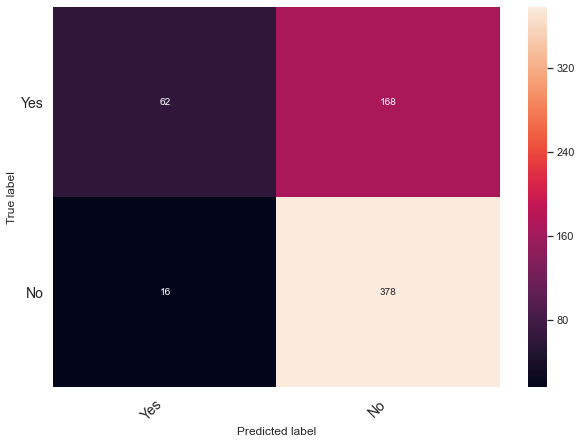

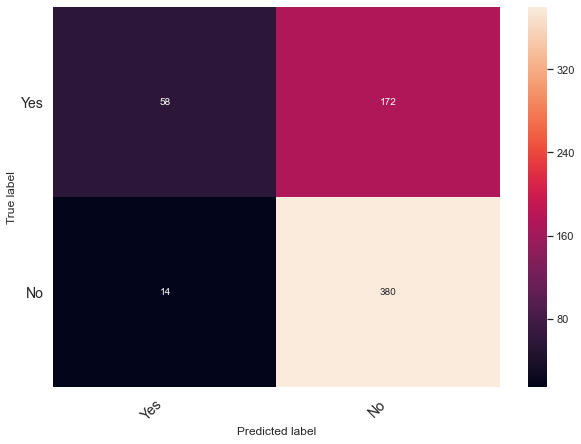

In [245]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_dengue,lr_bow_predict,labels=[1,0])
print_confusion_matrix(cm_bow,["Yes", "No"])
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_dengue,lr_tfidf_predict,labels=[1,0])
print_confusion_matrix(cm_tfidf,["Yes", "No"])

In [ ]:
#En caso para Peru, el score del modelo de Naive_Bayes no es muy bueno, ya que lo ideal seria es que el score esté cerca
#de 1. Sin embargo, su score es mejor que la de Brasil.

## Para Brasil

In [277]:
df_newsBrasil=df_news[df_news["Country"]=="Brazil"]
train_articleBrasil=df_newsBrasil.Article[:1480]
train_dengueBrasil=df_newsBrasil["Is there Dengue?"][:1480]
test_articleBrasil=df_newsBrasil.Article[1480:]
test_dengueBrasil=df_newsBrasil["Is there Dengue?"][1480:]
print(train_articleBrasil.shape,train_dengueBrasil.shape)
print(test_articleBrasil.shape,test_dengueBrasil.shape)

(1480,) (1480,)
(370,) (370,)


In [278]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
cv_train_articleBrasil=cv.fit_transform(train_articleBrasil)
cv_test_articleBrasil=cv.transform(test_articleBrasil)
print('BOW_cv_train:',cv_train_articleBrasil.shape)
print('BOW_cv_test:',cv_test_articleBrasil.shape)

BOW_cv_train: (1480, 12861)
BOW_cv_test: (370, 12861)


In [279]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
tv_train_articleBrasil=tv.fit_transform(train_articleBrasil)
tv_test_articleBrasil=tv.transform(test_articleBrasil)
print('Tfidf_train:',tv_train_articleBrasil.shape)
print('Tfidf_test:',tv_test_articleBrasil.shape)

Tfidf_train: (1480, 12861)
Tfidf_test: (370, 12861)


In [280]:
lb=LabelBinarizer()
dengue_data2=lb.fit_transform(df_newsBrasil["Is there Dengue?"])
print(dengue_data2.shape)

(1850, 1)


In [281]:
train_dengue2=dengue_data2[:1480]
test_dengue2=dengue_data2[1480:]
print(train_dengue2)
print(test_dengue2)

[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]

In [282]:
##Utilizo el modelo de MultinomialNB
mb=MultinomialNB(alpha=0.5)#El mejor alpha
mb_bow=mb.fit(cv_train_articleBrasil,train_dengue2)
print(mb_bow)

mb_tfidf=mb.fit(tv_train_articleBrasil,train_dengue2)
print(mb_tfidf)

MultinomialNB(alpha=0.5)
MultinomialNB(alpha=0.5)


C:\Users\PERSONAL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\PERSONAL\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [283]:
#Predicting the model for bag of words
mb_bow_predict=mb.predict(cv_test_articleBrasil)
print(mb_bow_predict)
##Predicting the model for tfidf features
mb_tfidf_predict=mb.predict(tv_test_articleBrasil)
print(mb_tfidf_predict)

[0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1
 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0]
[0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1
 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1

In [284]:
#Accuracy score for bag of words
mb_bow_score=accuracy_score(test_dengue2,mb_bow_predict)
print("mb_bow_score :",mb_bow_score)
#Accuracy score for tfidf features
mb_tfidf_score=accuracy_score(test_dengue2,mb_tfidf_predict)
print("mb_tfidf_score :",mb_tfidf_score)

mb_bow_score : 0.5918918918918918
mb_tfidf_score : 0.5891891891891892


In [285]:
#Classification report for bag of words 
mb_bow_report=classification_report(test_dengue2,mb_bow_predict,target_names=['Yes','No'])
print(mb_bow_report)

#Classification report for tfidf features
mb_tfidf_report=classification_report(test_dengue2,mb_tfidf_predict,target_names=['Yes','No'])
print(mb_tfidf_report)

              precision    recall  f1-score   support

         Yes       0.60      0.82      0.69       209
          No       0.56      0.29      0.38       161

    accuracy                           0.59       370
   macro avg       0.58      0.56      0.54       370
weighted avg       0.58      0.59      0.56       370

              precision    recall  f1-score   support

         Yes       0.60      0.83      0.70       209
          No       0.56      0.27      0.37       161

    accuracy                           0.59       370
   macro avg       0.58      0.55      0.53       370
weighted avg       0.58      0.59      0.55       370



Figure(720x504)
Figure(720x504)


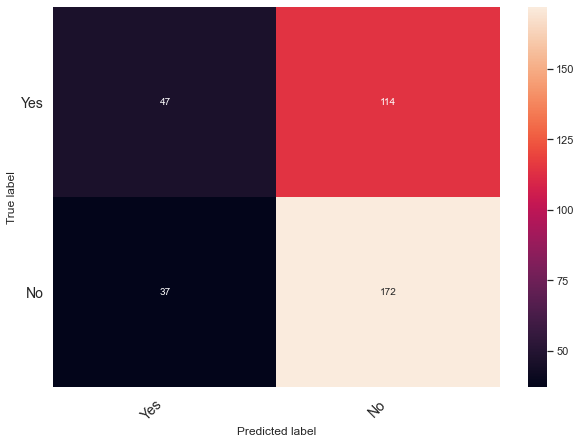

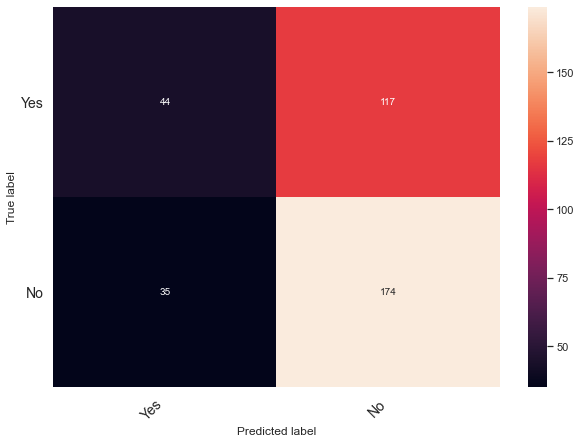

In [286]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_dengue2,mb_bow_predict,labels=[1,0])
print_confusion_matrix(cm_bow,["Yes", "No"])
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_dengue2,mb_tfidf_predict,labels=[1,0])
print_confusion_matrix(cm_tfidf,["Yes", "No"])

In [ ]:
#En caso para Brasil, el score del modelo de Naive_Bayes no es mejor que el del Peru y aun no resulta bueno para poder
#predecir las noticias de Dengue. Lo ideal es que esté cerca de 1.

## ACCURACY PERU:
mb_bow_score : 0.7051282051282052

mb_tfidf_score : 0.7019230769230769

## ACCURACY BRASIL:
mb_bow_score : 0.5918918918918918

mb_tfidf_score : 0.5891891891891892

## VISUALIZACION

In [111]:
#Agrupo la tabla por su pais, año y noticias
tmp = df_news.groupby(['Country', 'Year', 'Is there Dengue?'])['News'].value_counts()

In [112]:
df_test = pd.DataFrame(data={'N°News': tmp.values}, index=tmp.index).reset_index()

In [113]:
dfNo=df_test[(df_test['Is there Dengue?']=="No")&(df_test['Country']=="Brazil")] 
dfSi=df_test[(df_test['Is there Dengue?']=="Yes")&(df_test['Country']=="Brazil")]
traceSi = go.Scatter(
    x = dfSi['N°News'],
    y = dfSi['Year'],
    text=dfSi['News'],
    name="N° de Noticias que informan de Dengue",
    marker=dict(
        color="Blue",
    ),
    mode = "markers"
)

traceNo = go.Scatter(
    x = dfNo['N°News'],
    y = dfNo['Year'],
    text=dfNo['News'],
    name="N° de Noticias que NO informan de Dengue",
    marker=dict(
        color="Red",
    ),
    mode = "markers"
)

data = [traceSi, traceNo]
layout = dict(title = 'N° de Articulos de Brasil aparecidos en sus diarios con la palabra "Dengue"',
          xaxis = dict(title = 'N° News', showticklabels=True), 
          yaxis = dict(title = 'Year'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='DiariosBrasil')

In [ ]:
#Se puede observar que en el 2019 hubo mayor cantidad de articulos sobre Dengue en Brazil en sus respectivos diarios. En el 
#dataset de los casos de dengue muestran que hay 2226914 casos en Brasil en ese año, la mas alta hasta hora, por lo 
#que se puede deducir que hubo mucha relevancia sobre el tema. En segundo lugar esta en el 2020; sin embargo, 
#como vivimos en medio de una pandemia actual, lo más seguro es que no llegue al numero de articulos del 2019.

In [139]:
dfNo=df_test[(df_test['Is there Dengue?']=="No")&(df_test['Country']=="Peru")] 
dfSi=df_test[(df_test['Is there Dengue?']=="Yes")&(df_test['Country']=="Peru")]
traceSi = go.Scatter(
    x = dfSi['N°News'],
    y = dfSi['Year'],
    text=dfSi['News'],
    name="Informan de Dengue",
    marker=dict(
        color="Blue",
    ),
    mode = "markers"
)

traceNo = go.Scatter(
    x = dfNo['N°News'],
    y = dfNo['Year'],
    text=dfNo['News'],
    name="NO Informan de Dengue",
    marker=dict(
        color="Red",
    ),
    mode = "markers"
)

data = [traceSi, traceNo]
layout = dict(title = 'N° de Articulos de Peru aparecidos en sus diarios con la palabra "Dengue"',
          xaxis = dict(title = 'N° News', showticklabels=True), 
          yaxis = dict(title = 'Year'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='DiariosPeru')

In [ ]:
#Se puede observar que en el 2017 hubo mayor cantidad de articulos sobre Dengue en Peru en sus respectivos diarios. En el 
#dataset de los casos de dengue muestran que hay 76093.0 casos en Peru en ese año, y es el más alta hasta ahora, por lo que se
#puede deducir que hubo mucha relevancia sobre el tema.

In [117]:
dfPie=df_test[(df_test['Country']=="Brazil")] 
fig1 = px.pie(dfPie, values='N°News', names='Is there Dengue?', color_discrete_sequence=px.colors.sequential.RdBu, 
             title='Articulos de Brazil aparecidos en sus diarios con la palabra "Dengue"')
fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.show()

In [118]:
dfPie=df_test[(df_test['Country']=="Peru")] 
fig2 = px.pie(dfPie, values='N°News', names='Is there Dengue?', color_discrete_sequence=px.colors.sequential.RdBu,
            title='Articulos de Peru aparecidos en sus diarios con la palabra "Dengue"')
fig2.update_traces(textposition='inside', textinfo='percent+label')
fig2.show()

In [119]:
tmp2 = df_news.groupby(['Country', 'Year'])['Is there Dengue?'].value_counts()
df_test2 = pd.DataFrame(data={'N°News': tmp2.values}, index=tmp2.index).reset_index()

In [120]:
def mostrarData(year):
    dfSi=df_test2[(df_test2["Is there Dengue?"]=="Yes")&(df_test2["Year"]==str(year))]
    return dfSi

In [122]:
years=[2016, 2017, 2018, 2019, 2020]
# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}
figure['layout']['xaxis'] = {'title': 'Paises'}
figure['layout']['yaxis'] = {'range': [0, 500],'title': 'Numeros de articulos de Dengue'}
figure['layout']['showlegend'] = False
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '2016',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}

figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Year:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

year = 2016
dfSi=mostrarData(year)
traceS = go.Bar(
    x = list(dfSi["Country"]),y = list(dfSi["N°News"]),
    name="Brasil 2019",
    marker=dict(color="Red"),
)
figure['data']=[traceS]

for year in years:
    frame = {'data': [], 'name': str(year)}
    dfSi=mostrarData(year)
    traceS = go.Bar(
        x = list(dfSi["Country"]),y = list(dfSi["N°News"]),
        name="Brasil 2019",
        marker=dict(color="Blue"),
    )
    frame['data']=[traceS]
    
    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

figure['layout']['sliders'] = [sliders_dict]
iplot(figure)

In [ ]:
#Se observa que Peru informan más noticias sobre el dengue en estos ultimos 5 años.

In [ ]:
#NER SPACY ENTITIES
#PER: Named person or family.
#LOC: Name of politically or geographically defined location (cities, provinces, countries, international regions, bodies of water, mountains).
#ORG: Named corporate, governmental, or other organizational entity.
#MISC: Miscellaneous entities, e.g. events, nationalities, products or works of art

In [35]:
def contarElementosLista(lista):
    return {i:lista.count(i) for i in lista}

def mostrarD(country, year):
    df2=df_news[(df_news["Country"]==country)&(df_news["Is there Dengue?"]=="Yes")&(df_news["Year"]==str(year))]
    locations=[]
    for item in list(df2["NER Spacy"]):
        for text, loc in item:
            if (loc == "LOC" and "Dengue" not in text and "Coronavirus" not in text and "Virus" not in text and "Coronavírus" not in text):
                locations.append(text)
    D=contarElementosLista(locations)
    return D

In [36]:
D=mostrarD("Brazil", 2019)
traceS = go.Bar(
    x = list(D.keys()),y = list(D.values()),
    name="Brasil 2019",
    marker=dict(color="Red"),
)
data = [traceS]
layout = dict(title = 'Localidades mencionadas en los articulos de Brasil en 2019',
          xaxis = dict(title = 'Localidades', showticklabels=True), 
          yaxis = dict(title = 'Numeros de veces mencionadas'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='Brasil 2019')
print(len(D))

32


In [ ]:
#En el 2019 donde hubo mucha relevancia sobre el dengue en Brasil, Rio Preto  e Itajai es la localizacion más afectada 
#en Brasil. En total hay 32 localidades afectadas en Brasil.

In [37]:
D2=mostrarD("Peru", 2017)
traceS = go.Bar(
    x = list(D2.keys()),y = list(D2.values()),
    name="Peru2017",
    marker=dict(color="Red"),
)
data = [traceS]
layout = dict(title = 'Localidades mencionadas en los articulos de Peru en 2017',
          xaxis = dict(title = 'Localidades', showticklabels=True), 
          yaxis = dict(title = 'Numeros de veces mencionadas'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='Peru2017')
print(len(D2))

85


In [ ]:
#En el 2017 donde hubo mucha relevancia sobre el dengue en Peru, Piura es la localizacion más afectada en Peru. En total
#hay 85 localidades afectadas sobre el dengue

In [38]:
def mostrarDNews(news):
    df2=df_news[(df_news["News"]==news)&(df_news["Is there Dengue?"]=="Yes")]
    locations=[]
    for item in list(df2["NER Spacy"]):
        for text, loc in item:
            if (loc == "LOC" and "Dengue" not in text and "Coronavirus" not in text and "Virus" not in text and "Coronavírus" not in text):
                locations.append(text)
    D=contarElementosLista(locations)
    return D

In [39]:
D3=mostrarDNews("Oglobo")
traceS = go.Bar(
    x = list(D3.keys()),y = list(D3.values()),
    name="Oglobo",
    marker=dict(color="Red"),
)
data = [traceS]
layout = dict(title = 'Localidades mencionadas en los articulos de Oglobo',
          xaxis = dict(title = 'Localidades', showticklabels=True), 
          yaxis = dict(title = 'Numeros de veces mencionadas'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='Oglobo')
print(len(D3))

45


In [ ]:
#En estos ultimos 4 años, el diario Oglobo informó mayores casos de Dengue en Rio. En total informó 45 localidades

In [40]:
D4=mostrarDNews("DiarioDaRegiao")
traceS = go.Bar(
    x = list(D4.keys()),y = list(D4.values()),
    name="DiarioDaRegiao",
    marker=dict(color="Red"),
)
data = [traceS]
layout = dict(title = 'Localidades mencionadas en los articulos de DiarioDaRegiao',
          xaxis = dict(title = 'Localidades', showticklabels=True), 
          yaxis = dict(title = 'Numeros de veces mencionadas'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='DiarioDaRegiao')
print(len(D4))

42


In [ ]:
#En estos ultimos 4 años, el diario DiarioDaRegiao informó mayores casos de Dengue en Rio Preto. En total informó 42 localidades

In [41]:
D5=mostrarDNews("Diarinho")
traceS = go.Bar(
    x = list(D5.keys()),y = list(D5.values()),
    name="Diarinho",
    marker=dict(color="Red"),
)
data = [traceS]
layout = dict(title = 'Localidades mencionadas en los articulos de Diarinho',
          xaxis = dict(title = 'Localidades', showticklabels=True), 
          yaxis = dict(title = 'Numeros de veces mencionadas'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='Diarinho')
print(len(D5))

52


In [ ]:
#En estos ultimos 4 años, el diario Diarinho informó mayores casos de Dengue en Itajaí. En totalinformó 52 localidades

In [42]:
D6=mostrarDNews("DiarioElComercio")
traceS = go.Bar(
    x = list(D6.keys()),y = list(D6.values()),
    name="DiarioElComercio",
    marker=dict(color="Red"),
)
data = [traceS]
layout = dict(title = 'Localidades mencionadas en los articulos de Diario El Comercio',
          xaxis = dict(title = 'Localidades', showticklabels=True), 
          yaxis = dict(title = 'Numeros de veces mencionadas'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='DiarioElComercio')
print(len(D6))

38


In [ ]:
#En estos ultimos 4 años, el diario El Comercio informó mayores casos de Dengue en Piura. En total informó 38 localidades.
#No resulta coherente ya que los mayores casos se detectaron en la Amazonia peruana

In [43]:
D7=mostrarDNews("DiarioCorreo")
traceS = go.Bar(
    x = list(D7.keys()),y = list(D7.values()),
    name="DiarioCorreo",
    marker=dict(color="Red"),
)
data = [traceS]
layout = dict(title = 'Localidades mencionadas en los articulos de DiarioCorreo',
          xaxis = dict(title = 'Localidades', showticklabels=True), 
          yaxis = dict(title = 'Numeros de veces mencionadas'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='DiarioCorreo')
print(len(D7))

126


In [ ]:
#En estos ultimos 4 años, el diario Correo informó mayores casos de Dengue en Piura y Cusco. En total informó 126 localidades.
#No resulta coherente ya que los mayores casos se detectaron en la Amazonia peruana

In [28]:
D8=mostrarDNews("Peru21")
traceS = go.Bar(
    x = list(D8.keys()),y = list(D8.values()),
    name="Peru21",
    marker=dict(color="Red"),
)
data = [traceS]
layout = dict(title = 'Localidades mencionadas en los articulos de Peru 21',
          xaxis = dict(title = 'Localidades', showticklabels=True), 
          yaxis = dict(title = 'Numeros de veces mencionadas'),
          hovermode = 'closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='Peru21')
print(len(D8))

45


In [ ]:
#En estos ultimos 4 años, el diario Peru21 informó mayores casos de Dengue en Piura. En total informó 45 localidades.
#No resulta coherente ya que los mayores casos se detectaron en la Amazonia peruana.

## DASHBOARD

In [5]:
def contarElementosLista(lista):
    return {i:lista.count(i) for i in lista}

def mostrarD(country, year):
    df2=df_news[(df_news["Country"]==country)&(df_news["Is there Dengue?"]=="Yes")&(df_news["Year"]==str(year))]
    locations=[]
    for item in list(df2["NER Spacy"]):
        for text, loc in item:
            if (loc == "LOC" and "Dengue" not in text and "Coronavirus" not in text and "Virus" not in text and "Coronavírus" not in text):
                locations.append(text)
    D=contarElementosLista(locations)
    return D

In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

tmp2 = df_news.groupby(['Country', 'Year'])['Is there Dengue?'].value_counts()
df = pd.DataFrame(data={'N°News': tmp2.values}, index=tmp2.index).reset_index()

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.H3("Cantidad de Localizaciones por Pais y Año",
            style={"margin-bottom": "0px"},),
    dcc.RadioItems(
                id='xaxis-type',
                options=[{'label': i, 'value': i} for i in ['Brazil', 'Peru']],
                value='Brazil',
                labelStyle={'display': 'inline-block'}
            ),
    dcc.Slider(
        id='year-slider',
        min=2016,
        max=2020,
        value=2016,
        marks={str(year): str(year) for year in df['Year'].unique()},
        step=None
    ),
    dcc.Graph(id='graph-with-slider'),
])

@app.callback(
    Output('graph-with-slider', 'figure'),
    [Input('xaxis-type', 'value'),
     Input('year-slider', 'value')])

def update_figure(country, selected_year):
    D=mostrarD(country, selected_year)
    data={
    'Localizaciones':list(D.keys()),
    'N°Words':list(D.values()),
    }
    filtered_df=pd.DataFrame(data)
    fig = px.bar(filtered_df,
                 x="Localizaciones", y="N°Words",
           barmode="group")

    fig.update_layout(transition_duration=500)
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Jul/2020 18:46:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 18:46:37] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 18:46:37] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 18:46:37] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 18:46:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 18:47:09] "POST /_dash-update-component HTTP/1.1" 200 -


In [7]:
def mostrarDNews(news):
    df2=df_news[(df_news["News"]==news)&(df_news["Is there Dengue?"]=="Yes")]
    locations=[]
    for item in list(df2["NER Spacy"]):
        for text, loc in item:
            if (loc == "LOC" and "Dengue" not in text and "Coronavirus" not in text and "Virus" not in text and "Coronavírus" not in text):
                locations.append(text)
    D=contarElementosLista(locations)
    return D

In [8]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

tmp2 = df_news.groupby(['Country', 'Year'])['Is there Dengue?'].value_counts()
df = pd.DataFrame(data={'N°News': tmp2.values}, index=tmp2.index).reset_index()

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.H3("Cantidad de Localizaciones por Diarios",
            style={"margin-bottom": "0px"},),
    
    dcc.RadioItems(
                id='xaxis-type',
                options=[{'label': i, 'value': i} for i in ['Oglobo', 'Diarinho', 'DiarioDaRegiao', 'DiarioElComercio',
                                                           'DiarioCorreo', 'Peru21']],
                value='Oglobo',
                labelStyle={'display': 'inline-block'}
            ),
    
    dcc.Graph(id='graph-with-slider'),
])

@app.callback(
    Output('graph-with-slider', 'figure'),
    [Input('xaxis-type', 'value')])

def update_figure(news):
    D=mostrarDNews(news)
    data={
    'Localizaciones':list(D.keys()),
    'N°Words':list(D.values()),
    }
    filtered_df=pd.DataFrame(data)
    fig = px.bar(filtered_df,
                 x="Localizaciones", y="N°Words",
           barmode="group")

    fig.update_layout(transition_duration=500)
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Jul/2020 15:46:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 15:46:11] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 15:46:11] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 15:46:11] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 15:46:17] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 15:46:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 15:46:25] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 15:46:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Jul/2020 15:46:35] "POST /_dash-update-component HTTP/1.1" 200 -
